# Baseline model – Decision-tree classifier for ECG-based Chagas detection
This notebook builds a single CART decision tree (`sklearn.tree.DecisionTreeClassifier`) as an initial benchmark.

## Environment setup

### Import libraries

In [3]:
import joblib
import os
import sys
import random

import numpy as np
import pandas as pd
from scipy.stats import randint

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    precision_recall_fscore_support,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid

# Reproducibility seed
RANDOM_STATE = 2025
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

### Load preprocessed datasets

In [2]:
# Path to the folder containing preprocessed data
DATA_DIR = 'data/prepared'

# train_full = np.load(f'{DATA_DIR}/train_full_parts0-6.npz')
train = np.load(f'{DATA_DIR}/train_bal_parts0-6_aug.npz')
val = np.load(f'{DATA_DIR}/val_parts0-6.npz')
test = np.load(f'{DATA_DIR}/test_external.npz')

# Extract arrays and labels from the loaded data
#X_train_full, y_train_full = train_full['X'], train_full['y']
X_train, y_train = train['X'], train['y']
X_val, y_val = val['X'], val['y']
X_test, y_test = test['X'], test['y']

# Check array shapes 
print('Train :', X_train.shape,  'Positives:', y_train.sum())
print('Val   :', X_val.shape,    'Positives:', y_val.sum())
print('Test  :', X_test.shape,   'Positives:', y_test.sum())

Train : (17880, 2920, 12) Positives: 4470
Val   : (27873, 2920, 12) Positives: 559
Test  : (23430, 2920, 12) Positives: 1631


## Modeling

### Train baseline decision tree

In [ ]:
# Flatten ECGs to 1-D feature vectors
X_train_flat = X_train.reshape(len(X_train), -1)

# Fit decision tree with class weighting
tree = DecisionTreeClassifier(
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
tree.fit(X_train_flat, y_train)

# Save for reuse
# joblib.dump(tree, 'baseline_tree.joblib')
# print('Baseline tree saved to baseline_tree.joblib')

KeyboardInterrupt: 

In [ ]:
# Hyperparameter tuning using GridSearchCV
search = GridSearchCV(
    DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE),
    param_grid={'max_depth': [5, 10, 20, None],
                'min_samples_split': [2, 5, 10]},
    scoring='roc_auc',
    cv=5,
    n_jobs=1,
)

# Fit the search to the training data
search.fit(X_train_flat, y_train)

tree = search.best_estimator_ 

print('Best parameters    :', search.best_params_)

In [ ]:
# Set parameters for RandomizedSearchCV
param_dist = {'max_depth': [5, 10, 20, None],
              'min_samples_split': randint(2, 11)}

# Initialize RandomizedSearchCV
search = RandomizedSearchCV(
    DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE),
    param_distributions=param_dist,
    n_iter=6,          # eight random combos
    scoring='roc_auc',
    # cv=3, 
    n_jobs=1,
    verbose=2,
)

# Flatten ECGs to 1-D feature vectors
X_train_flat = X_train.reshape(len(X_train), -1)

# Fit the search to the training data
search.fit(X_train_flat, y_train)

# Get the best estimator
tree = search.best_estimator_

print(f'Best parameters: {search.best_params_}')

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [ ]:
# 1-D feature matrices
X_train_flat, y_train, X_val_flat, y_val = (
    X_train.reshape(len(X_train), -1), y_train,
    X_val.reshape(len(X_val), -1), y_val
)

# Set up grid search for hyperparameter tuning
param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
}

# Create variable to store the best score and parameters
best_score, best_params, best_model = -1, None, None

# Perform grid search over the parameter grid
for params in ParameterGrid(param_grid):
    clf = DecisionTreeClassifier(
        **params,
        class_weight='balanced',
        random_state=RANDOM_STATE,
    )
    # Fit the classifier to the training data
    clf.fit(X_train_flat, y_train)

    # Validate the classifier on the validation set
    val_prob = clf.predict_proba(X_val_flat)[:, 1]

    # Calculate the AUROC score
    score = roc_auc_score(y_val, val_prob)

    # Update the best score and parameters if the current score is better
    if score > best_score:
        best_score, best_params, best_model = score, params, clf

# Print the best score and parameters
print(f'Best AUROC on val : {best_score:.3f}')
print(f'Best params       : {best_params}')

# Set the best model to the tree variable
tree = best_model

### Evaluation

Train metrics
  accuracy     0.867
  AUROC        0.945
  AUPRC        0.825
  precision    0.659
  recall       0.969
  specificity  0.833
  F1           0.784



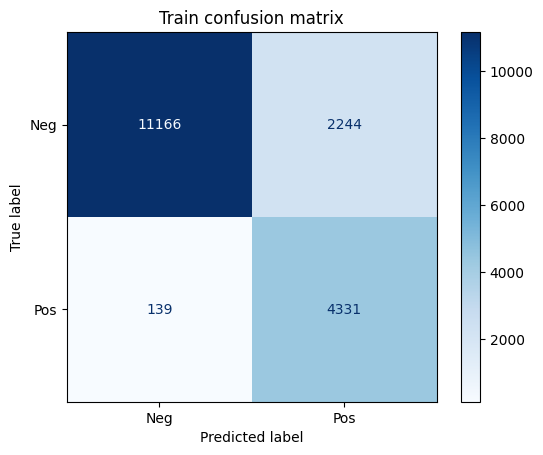

Validation metrics
  accuracy     0.679
  AUROC        0.597
  AUPRC        0.030
  precision    0.034
  recall       0.547
  specificity  0.682
  F1           0.064



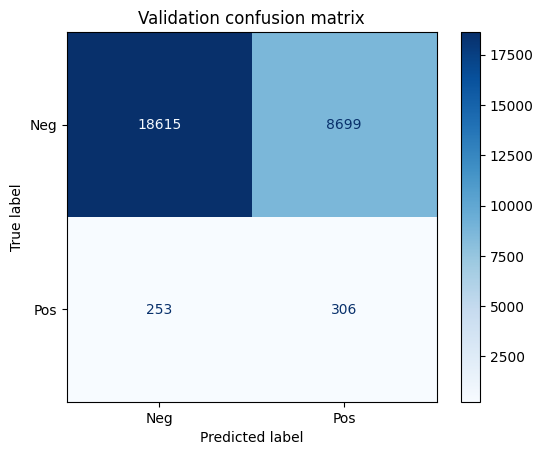

External test metrics
  accuracy     0.608
  AUROC        0.503
  AUPRC        0.069
  precision    0.057
  recall       0.300
  specificity  0.631
  F1           0.096



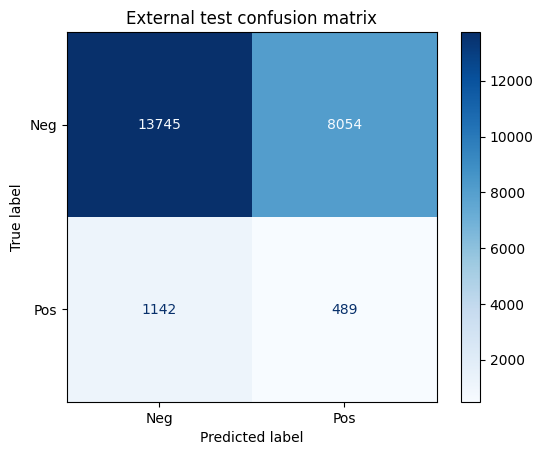

In [ ]:
def report(name, X_split, y_split, plot_cm=True):
    """
    Create a report of the model's performance on the given split.
    Args:
        name (str): Name of the dataset split (e.g., 'Train', 'Validation', 'External test').
        X_split (np.ndarray): Feature matrix for the split.
        y_split (np.ndarray): True labels for the split.
        plot_cm (bool): Whether to plot the confusion matrix.
    Returns:
        Prints the performance metrics and confusion matrix.
    """
    y_prob = tree.predict_proba(X_split)[:, 1]
    y_pred = tree.predict(X_split)
    acc = accuracy_score(y_split, y_pred)
    auroc = roc_auc_score(y_split, y_prob)
    auprc = average_precision_score(y_split, y_prob)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_split, y_pred, average='binary', zero_division=0
    )
    cm = confusion_matrix(y_split, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f'{name} metrics')
    print(f'  accuracy     {acc:.3f}')
    print(f'  AUROC        {auroc:.3f}')
    print(f'  AUPRC        {auprc:.3f}')
    print(f'  precision    {prec:.3f}')
    print(f'  recall       {rec:.3f}')
    print(f'  specificity  {specificity:.3f}')
    print(f'  F1           {f1:.3f}\n')

    if plot_cm:
        ConfusionMatrixDisplay(cm, display_labels=['Neg', 'Pos']).plot(cmap='Blues')
        plt.title(f'{name} confusion matrix')
        plt.show()


In [ ]:
# Flatten datasets for evaluation
X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat = X_val.reshape(len(X_val), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

# Report performance on train, validation, and external test sets
report('Train', X_train_flat, y_train)
report('Validation', X_val_flat, y_val)
report('External test', X_test_flat, y_test)

## Conclusion
Summarize baseline results and outline next steps for model improvements and deeper analyses.